## Learning priors

In [37]:
# setup the environment
import nengo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import cPickle as pickle
% matplotlib inline
np.set_printoptions(threshold='nan')

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

import seaborn as sns
sns.set_context("talk")
sns.set_style('whitegrid')

### Two stage hierarchichal bayes model for generating training data

In [5]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# our function domain is thetas (i.e., age from 1 to 120)
# Remember thetas is same as Z in our plate notation (shown later)
# We are also assuming discrete values for age, because people 
# usually report integers for age when asked to predict.
thetas = np.linspace(start=1, stop=max_age, num=max_age)

# compute likelihood 
def likelihood(x):
    x = int(x)
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

# computer prior
def skew_gauss(skew, loc, scale):
    prior = [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 
    prior = prior/sum(prior)
    return prior

# computer posterior
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post

The two stage hierarchical bayes model is summarised in the <a href="https://en.wikipedia.org/wiki/Plate_notation">Plate notation</a> as follows:
![](http://i.imgur.com/gmLKIjJ.png)

The data is generated in the forward direction ($\alpha \longrightarrow Z \longrightarrow X$). Then only $X$ is accessible to the model, along with the "knowledge" of how this was generated. The actual parameters for $Z$ and $\alpha$ are hidden from the model. The task is then to infer the most likely $Z$ and $\alpha$ given the observed sample $X$.

In [6]:
# These two functions are used to generate the sample X. 

# Gaussian lifespans
skew_original = -6    # fixed parameter
loc_original = 99    # to be estimated
scale_original = 27   # fixed parameter


# Function to sample discrete random values from a skewed gaussian distribution
def randn_skew(n_samples, skew=0.0, loc=0.0, scale=1.0):
    # gaussian lifespans
    probs =  skew_gauss(skew, loc, scale) 
    samples = np.random.choice(thetas, size=n_samples, replace=True, p=probs)   
    samples = list(samples)  #convert ndarray to a python list
    return samples


# Function to draw samples X for the given number of trials
# prior gives the total lifespan, but x (samples) are current ages observed
# so x should be <= total lifespan
def draw(n_trials, n_samples):
    x_vector = []
    for i in np.arange(n_trials):
        # generating Z from alpha
        z_vector = randn_skew(n_samples=n_samples, skew=skew_original, loc=loc_original, scale=scale_original)  
        x_vector.append(np.asarray([np.random.randint(low=1, high=th+1) for th in z_vector]))   # X from Z
    return x_vector

### Prior Space Construction

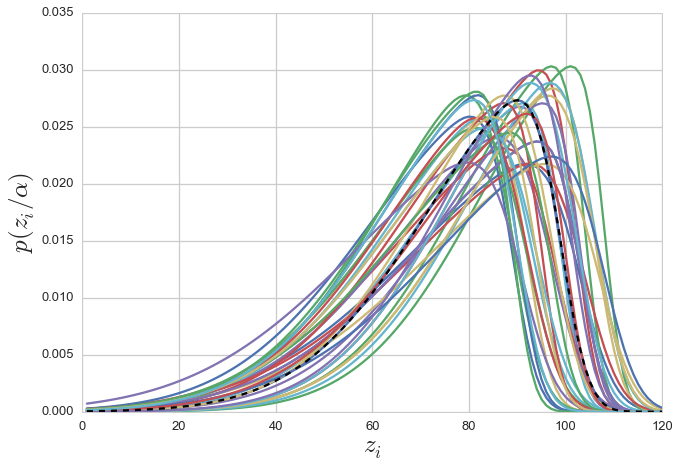

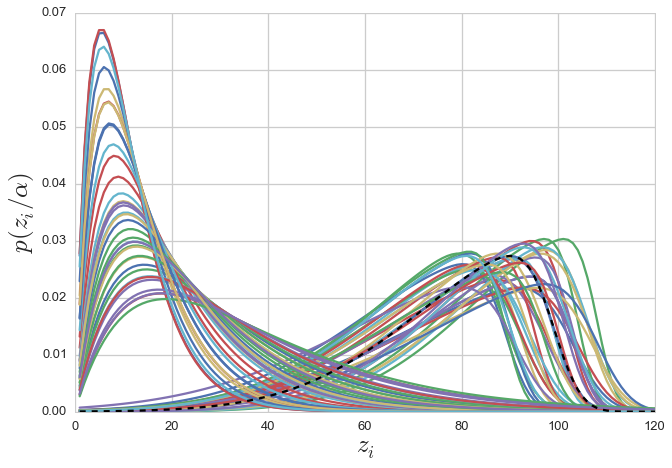

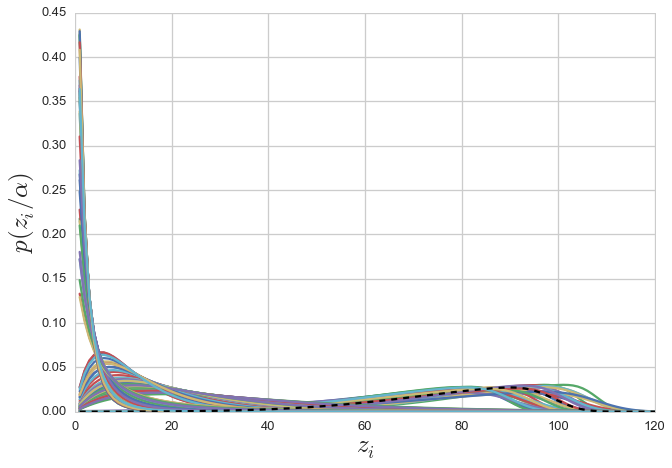

Prior Space size: 108


In [18]:
lifespan_pred_index = 24  #6  
pharaohs_pred_index = 44  #14 
waittime_pred_index = 84  #24 
pred_index = lifespan_pred_index

N = 108/3  #27/3
M = N 


# search space 54
alpha = np.random.randint(89, 109, M)    #loc or shift
alpha2 = np.random.randint(25, 35, M)     #scale 
alpha3 = np.random.randint(-8, -4, M)    #skew  )

prior = np.zeros((M, max_age))
    

j = 0       
for _ in range(M):
    prior[j, :] =  skew_gauss(skew=alpha3[j], loc=alpha[j], scale=alpha2[j]) #new_prior[j,:] #
    j = j+1

    
#manually add the optimal prior
prior[lifespan_pred_index,:] = skew_gauss(-6, 99, 27) 

plt.figure()
plt.plot(thetas, prior.T)
plt.plot(thetas, prior[lifespan_pred_index, :], 'k--') 
plt.ylabel(r'$p(z_i/\alpha)$', fontsize=25)
plt.xlabel(r'$z_i$', fontsize=25)
plt.show()

# --------------------------------------------------------------------------------------------------------- #

# add Erlang priors


a = 2     # shape: should be a positive integer - fixed at 2 as in the Griffiths paper
loc = 0   # fixed at 0
scale_list = np.random.uniform(5, 20, N)
for scale in scale_list: 
    P = [(st.erlang.pdf(p, a=a, loc=loc, scale=scale)) for p in thetas]
    P = P/sum(P)
    P = np.asarray(P)
    P = np.reshape(P, (1, max_age))
    prior = np.append(prior, P, axis=0)
    M = M+1
    

P = [(st.erlang.pdf(p, a=2, loc=0, scale=17.9)) for p in thetas]  #5
P = P/sum(P)
prior[pharaohs_pred_index,:] = P
    
plt.figure()
_ = plt.plot(thetas, prior.T)    
_ = plt.plot(thetas, prior[pred_index, :], 'k--')
plt.ylabel(r'$p(z_i/\alpha)$', fontsize=25)
plt.xlabel(r'$z_i$', fontsize=25)
plt.show()

# --------------------------------------------------------------------------------------------------------- #

# add Power Law/ Pareto priors

loc = -7.5 # fixed
scale = 1  # fixed
b = np.random.uniform(1, 5, N)
i = 0
for _ in range(N):
    P = [(st.pareto.pdf(p, b=b[i], loc=loc, scale=scale)) for p in thetas]
    P = P/sum(P)
    P = np.asarray(P)
    P = np.reshape(P, (1, max_age))
    prior = np.append(prior, P, axis=0)
    M = M+1
    i = i+1

P = [(st.pareto.pdf(p, b=2.43, loc=-7.5, scale=1)) for p in thetas]
P = P/sum(P)
prior[waittime_pred_index,:] = P 

plt.figure()
_ = plt.plot(thetas, prior.T)    
_ = plt.plot(thetas, prior[pred_index, :], 'k--')
plt.ylabel(r'$p(z_i/\alpha)$', fontsize=25)
plt.xlabel(r'$z_i$', fontsize=25)
plt.show()

# --------------------------------------------------------------------------------------------------------- #

# Search Space
# priors conditioned on alpha: p(Z/A)    
pZA = prior
logpZA = np.log(pZA)  
print "Prior Space size:" , M

In [28]:
"""
# Storing or using a store the prior space
data = { 'prior':prior
       }
#pickle.dump(data, open(".p", 'wb'))

data = pickle.load(open("27fspace.p", 'rb'))
prior = data['prior']
_ = plt.plot(thetas, prior.T)
_ = plt.plot(thetas, skew_gauss(-6, 99,27), 'k--')
plt.show()
pZA = prior
logpZA = np.log(pZA)
M = len(prior)
"""

In [52]:
from IPython.display import Latex


### Stepwise Expectation Maximization (algorithm implementation in math)

$$
\begin{split}
& \mu \leftarrow \text{initialization; $k=0$}  \\
& \text{foreach observation i = 1,...,n}: \\
& \quad s'_{i} = \sum_{z_i} T(x_i, z_i) \log \left( p(z_i | \alpha) / z_i \right) \\
& \quad n_{k} = (k+2)^{-\beta} \\
& \quad \mu = (1-n_{k}) \mu + n_{k}s'_{i} \\
& \quad \alpha^{(t)} = \text{argmax}(\mu) , \quad \text{$k \leftarrow  k+1$}
\end{split}
$$

By the generalized Bayes rule, we know:
$$
\begin{split}
& T(x_i, z_i) = p(z_i | x_i, \alpha^{(t)}) = \frac{p(z_i, x_i | \alpha^{(t)})}{ \sum_{z_i} p(z_i, x_i | \alpha^{(t)}) } \\
& \text{where } p(x_i, z_i | \alpha) = p(x_i | z_i) p(z_i | \alpha^{(t)}) \\
\end{split}
$$

<br>
Here $s'_{i}$ is the sufficient statistics for the $\textit{i}$-th observation. Instead of summing these over $n$ observations as in the regular EM algorithm, here we interpolate between $\mu$ and $s'_{i}$ based on a stepsize $n_{k}$, where $k$ is the number of updates made to $\mu$ so far. Thus Stepwise EM leads to a stochastic process where we approximate the update in each iteration with a single sensory observation. However, since a single sample is a bad approximation, we interpolate between the current observation ($s'_{i}$) and the set of statistics corresponding to the previous observations (current $\mu$). Results from stochastic approximation literature state that $\sum_{k=0}^{\inf} n_{k} = \inf$ and $\sum_{k=0}^{\inf} n_{k}^2 < \inf$ are sufficient conditions to guarantee convergence to a local optimum. This implies that for $n_{k} = (k+2)^{-\beta}$, any $0.5 < \beta <= 1$ is valid. In general, smaller $\beta$ would lead to larger updates and quicker decay of the old sufficient statistics ($\mu$). This can lead to fast progress but can also generate instability~\cite{liang2009online}. In our model, we use $\beta = 0.65$.


In [54]:
from nengo.utils.progress import ProgressTracker
import math

# Function to compute the likelihood of each  
# 'x' in the Sample X (x_vector)
def compute_lik(x_vector):
    lik = np.zeros((len(x_vector), max_age))
    i = 0
    for obs in x_vector:
        lik[i,:] = likelihood(obs)    #pXZ
        i = i+1
    return lik    

    
global total_l, total_s
total_l = 0
total_s = 0
# Online EM where the stored terms are decayed away
# Adding iterations for each example (1) similar to STM cycling
# around hippocampus while being consolidated in the LTM.
# 1) Inner terations: As each example comes in, we update the stored 
# terms and  iterate 'num_inner_iter' times for each individual example.
# 2) Outer Iterations: After all examples have been received, we repeat the 
# entire process/iterate by reusing the same set of examples 'num_iter' times.
# This might be similar to refelcting on past experiences etc.

# no of iterations per sample really matter
# no of outer iterations don't  make much difference for our purposes
def stepwise_em_iterative(x, num_iter=1, num_inner_iter=3): 
    _pXZ = compute_lik(x)
    a = np.random.randint(0, M) 
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far
    beta = 0.65        # 1 gave 40% and 0.5 gave 98% accuracy
    _pXZ_list = list(enumerate(_pXZ))
    
    for r in range(num_iter):
        np.random.shuffle(_pXZ_list) 
        for i, p in _pXZ_list:
            for _ in range(num_inner_iter): 
                L = np.zeros(M)
                pxz = p * pZA[a, :]
                L += (pxz / np.sum(pxz)).dot(logpZA.T/10.0)
                
                gamma = np.power(float(k+2), -beta)  
                S = gamma*L + (1-gamma)*S
                max_a = a = np.argmax(S)
                k = k + 1
        
    
    #print "\n Final max_a: ", max_a   
    global total_l, total_s
    err = rmse(pZA[a, :], pZA[pred_index, :])
    if err > 0.003:
        total_l = total_l + 1
    else:
        total_s = total_s + 1
    return max_a


# Accuracy defined based on +/2 withing the optimal value
def grade_solution(f, n_trials, n_samples, name=None, plot=True):
    X = draw(n_trials, n_samples)
    
    correct = 0
    err = np.empty(n_trials)
    with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
    with ProgressTracker(n_trials, True, name) as progress:
        for j in range(n_trials):
            a_est = f(X[j])
            if a_est == pred_index:
                correct += 1    
            err[j] = rmse(pZA[a_est, :], pZA[pred_index, :]) 
            progress.step()
    acc = correct / float(n_trials)
    
    if plot:
        plt.figure()
        plt.title("RMSE of converged priors", fontsize=18)
        plt.plot(err, 'o')
        plt.xlabel("number of trials", fontsize=18)
        plt.ylabel("RMSE", fontsize=18)
        sns.despine(offset=10)
        plt.show()
        
        print "Average RMSE: ", np.average(err)
        print "Max RMSE: ", max(err)
    return acc


def rmse(predictions, targets):
    return  np.sqrt(((predictions - targets) ** 2).mean()) 

### Plot RMSE statistics for the chosen prior space

Number of distributions with RMSE greater than 0.025: 93
Number of distributions with RMSE less than 0.025: 15


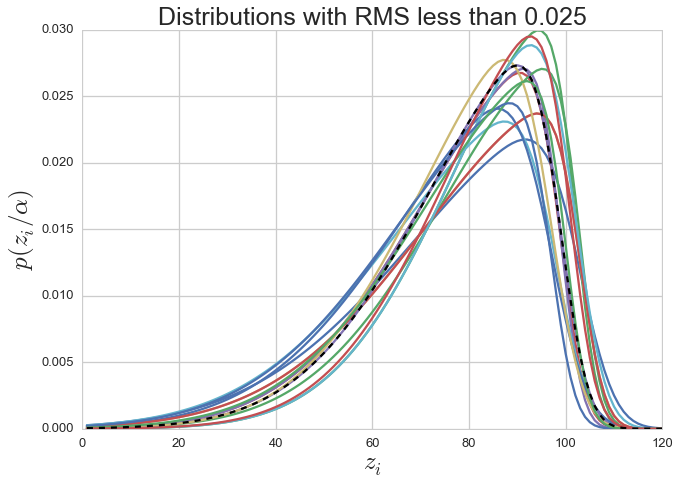

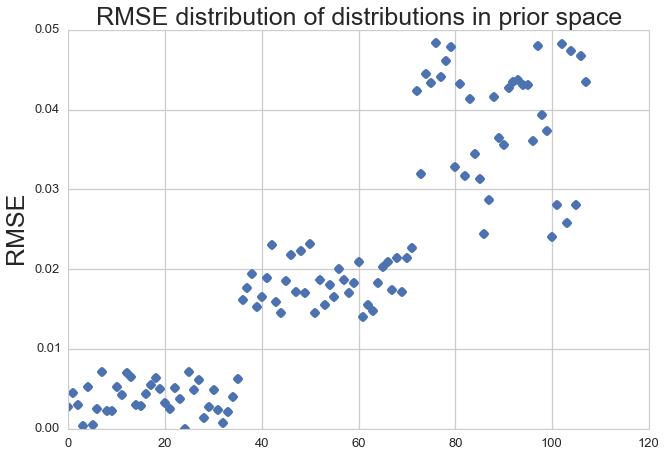

In [55]:
count_g = 0
count_s = 0
total = M
err = np.empty(total)
plt.figure()
for i in range(total):
    b = rmse(pZA[i, :], pZA[pred_index, :])
    err[i] = b
    if b > 0.003:
        count_g = count_g + 1
    else:
        plt.plot(thetas, pZA[i, :])
        count_s = count_s + 1

plt.plot(thetas, prior[pred_index, :], 'k--')        
plt.ylabel(r'$p(z_i/\alpha)$', fontsize=25)
plt.xlabel(r'$z_i$', fontsize=25)        
plt.title("Distributions with RMS less than 0.025", fontsize=25)

plt.figure()
plt.plot(err, 'o') 
plt.ylabel('RMSE', fontsize=25)
plt.title("RMSE distribution of distributions in prior space", fontsize=25)


print "Number of distributions with RMSE greater than 0.025:", count_g
print "Number of distributions with RMSE less than 0.025:", count_s

Initializing finished in 0:00:01.                                               
Stepwise Iterative EM finished in 0:02:13.                                      


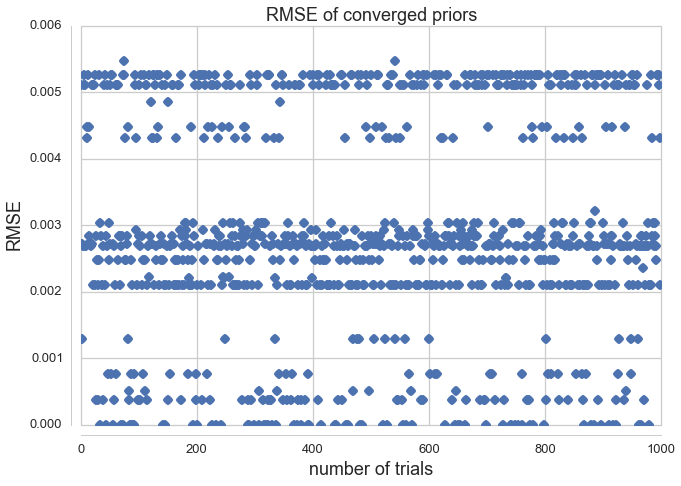

Average RMSE:  0.00290609505731
Max RMSE:  0.00547663068331


0.067

In [56]:
estimate_list = []
total_l = 0
total_s = 0
grade_solution(stepwise_em_iterative, n_trials=1000, n_samples=500, name="Stepwise Iterative EM")

In [58]:
print "Number of trials with RMSE greater than 0.003: ", total_l
print "Number of trials with RMSE smaller than 0.003: ", total_s

Number of trials with RMSE greater than 0.003:  332
Number of trials with RMSE smaller than 0.003:  668


RMSE:  0.00520694165734


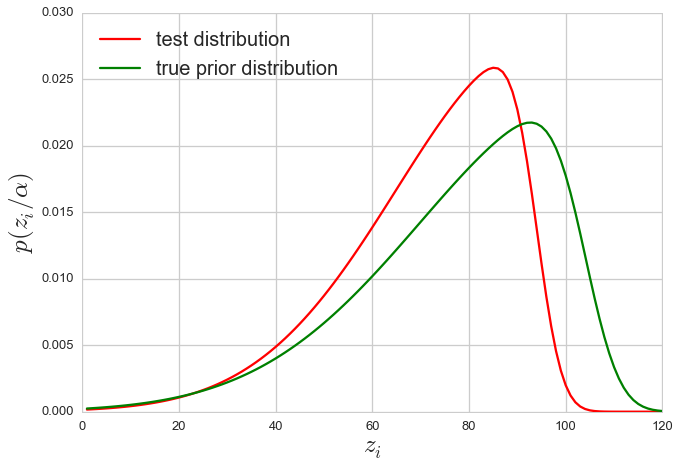

In [94]:
# Plot any distribution in the prior space to look at it relative to the optimal
idx = 34
plt.figure()
plt.plot(thetas, pZA[idx, :], 'r', label="test distribution")  # random distribution in the prior space
plt.plot(thetas, pZA[pred_index, :], 'g', label="true prior distribution")  # optimal
plt.ylabel(r'$p(z_i/\alpha)$', fontsize=25)
plt.xlabel(r'$z_i$', fontsize=25) 
plt.legend(loc='upper left', fontsize=20)
print "RMSE: ", rmse(pZA[idx, :], pZA[pred_index, :])

## A Neural model for learning priors

### Winner Take All Network

Adapted from:<br> <br> Jan Gosmann, Aaron R. Voelker, and Chris Eliasmith. A spiking independent accumulator model for winner-take-all computation. In Proceedings of the 39th Annual Conference of the Cognitive Science Society. London, UK, 2017. Cognitive Science Society. <br> URL: https://mindmodeling.org/cogsci2017/papers/0405/index.html.

In [62]:
def IA(d, n_neurons, dt, share_thresholding_intercepts=False):
    bar_beta = 2.  # should be >= 1 + max_input * tau2 / tau1
    tau_model1 = 0.1
    tau_model2 = 0.1
    tau_actual = 0.1

    # dynamics put into continuous LTI form:
    #   dot{x1} = A1x1 + A2x2 + Bu
    # where x1 is the state variable for layer 1 and
    #       x2 is the state variable for layer 2
    # note that from the perspective of Principle 3, A2x2 is treated
    # as an "input" similar to u
    I = np.eye(d)
    inhibit = 1 - I
    B = 1. / tau_model1  # input -> layer 1
    A1 = 0  # (integrator) layer1 -> layer1
    A2 = (I - bar_beta * inhibit) / tau_model2  # layer 2 -> layer 1

    n_neurons_threshold = 50  
    n_neurons_x = n_neurons - n_neurons_threshold
    assert n_neurons_x > 0
    threshold = 0.8

    with nengo.Network(label="IA") as net:
        net.input = nengo.Node(size_in=d)
        x = nengo.networks.EnsembleArray(
            n_neurons_x, d,
            eval_points=nengo.dists.Uniform(0., 1.),
            intercepts=nengo.dists.Uniform(0., 1.),
            encoders=nengo.dists.Choice([[1.]]), label="Layer 1")
        net.x = x
        nengo.Connection(x.output, x.input, transform=tau_actual * A1 + I,
                         synapse=tau_actual)

        nengo.Connection(
            net.input, x.input,
            transform=tau_actual * B,
            synapse=tau_actual)

        with nengo.presets.ThresholdingEnsembles(0.):
            thresholding = nengo.networks.EnsembleArray(
                n_neurons_threshold, d, label="Layer 2")
            if share_thresholding_intercepts:
                for e in thresholding.ensembles:
                    e.intercepts = nengo.dists.Exponential(
                        0.15, 0., 1.).sample(n_neurons_threshold)
            net.output = thresholding.add_output('heaviside', lambda x: x > 0.)

        bias = nengo.Node(1., label="Bias")

        nengo.Connection(x.output, thresholding.input, synapse=0.005)
        nengo.Connection(
            bias, thresholding.input, transform=-threshold * np.ones((d, 1)))
        nengo.Connection(
            thresholding.heaviside, x.input,
            transform=tau_actual * A2, synapse=tau_actual)

    return net


### Memory Network

In [63]:
# Adapted from Nengo Networks
from nengo.networks import EnsembleArray


def InputGatedMemory(n_neurons, n_neurons_diff, dimensions, feedback=1.0,
                     difference_gain=1.0, recurrent_synapse=0.1,
                     difference_synapse=None, net=None, **kwargs):
    """Stores a given vector in memory, with input controlled by a gate.
    Parameters
    ----------
    n_neurons : int
        Number of neurons per dimension in the vector.
    dimensions : int
        Dimensionality of the vector.
    feedback : float, optional (Default: 1.0)
        Strength of the recurrent connection from the memory to itself.
    difference_gain : float, optional (Default: 1.0)
        Strength of the connection from the difference ensembles to the
        memory ensembles.
    recurrent_synapse : float, optional (Default: 0.1)
    difference_synapse : Synapse (Default: None)
        If None, ...
    kwargs
        Keyword arguments passed through to ``nengo.Network``.
    Returns
    -------
    net : Network
        The newly built memory network, or the provided ``net``.
    Attributes
    ----------
    net.diff : EnsembleArray
        Represents the difference between the desired vector and
        the current vector represented by ``mem``.
    net.gate : Node
        With input of 0, the network is not gated, and ``mem`` will be updated
        to minimize ``diff``. With input greater than 0, the network will be
        increasingly gated such that ``mem`` will retain its current value,
        and ``diff`` will be inhibited.
    net.input : Node
        The desired vector.
    net.mem : EnsembleArray
        Integrative population that stores the vector.
    net.output : Node
        The vector currently represented by ``mem``.
    net.reset : Node
        With positive input, the ``mem`` population will be inhibited,
        effectively wiping out the vector currently being remembered.
    """
    if net is None:
        kwargs.setdefault('label', "Input gated memory")
        net = nengo.Network(**kwargs)
    else:
        warnings.warn("The 'net' argument is deprecated.", DeprecationWarning)

    if difference_synapse is None:
        difference_synapse = recurrent_synapse

    n_total_neurons = n_neurons * dimensions
    n_total_neurons_diff = n_neurons_diff * dimensions

    with net:
        # integrator to store value
        
        mem_net = nengo.Network()
        mem_net.config[nengo.Ensemble].encoders = nengo.dists.Choice([[-1.]]) 
        mem_net.config[nengo.Ensemble].radius = 1
        mem_net.config[nengo.Ensemble].eval_points=nengo.dists.Uniform(-1, 0.0) 
        mem_net.config[nengo.Ensemble].intercepts = nengo.dists.Uniform(-0.6, 1.) 
        
    
        with mem_net:
            net.mem = EnsembleArray(n_neurons, dimensions, label="mem")
        nengo.Connection(net.mem.output, net.mem.input,
                         transform=feedback,
                         synapse=recurrent_synapse)

        
        diff_net = nengo.Network()
        diff_net.config[nengo.Ensemble].radius = 0.5
        diff_net.config[nengo.Ensemble].eval_points=nengo.dists.Uniform(-0.5, 0.5)
        with diff_net:
            # calculate difference between stored value and input
            net.diff = EnsembleArray(n_neurons_diff, dimensions, label="diff")
        nengo.Connection(net.mem.output, net.diff.input, transform=-1)

        # feed difference into integrator
        nengo.Connection(net.diff.output, net.mem.input,
                         transform=difference_gain,
                         synapse=difference_synapse)

        # gate difference (if gate==0, update stored value,
        # otherwise retain stored value)
        net.gate = nengo.Node(size_in=1)
        net.diff.add_neuron_input()
        nengo.Connection(net.gate, net.diff.neuron_input,
                         transform=np.ones((n_total_neurons_diff, 1)) * -10,
                         synapse=None)

        # reset input (if reset=1, remove all values, and set to 0)
        net.reset = nengo.Node(size_in=1)
        nengo.Connection(net.reset, net.mem.add_neuron_input(),
                         transform=np.ones((n_total_neurons, 1)) * -3,
                         synapse=None)

    net.input = net.diff.input
    net.output = net.mem.output

    return net

### Function space representation

Compute basis using the approach described in: <br> <br>
Sugandha Sharma, Aaron R. Voelker, and Chris Eliasmith. A spiking neural bayesian model of life span inference. In Proceedings of the 39th Annual Conference of the Cognitive Science Society. London, UK, 2017. Cognitive Science Society. <br>
URL: https://mindmodeling.org/cogsci2017/papers/0591/index.html.

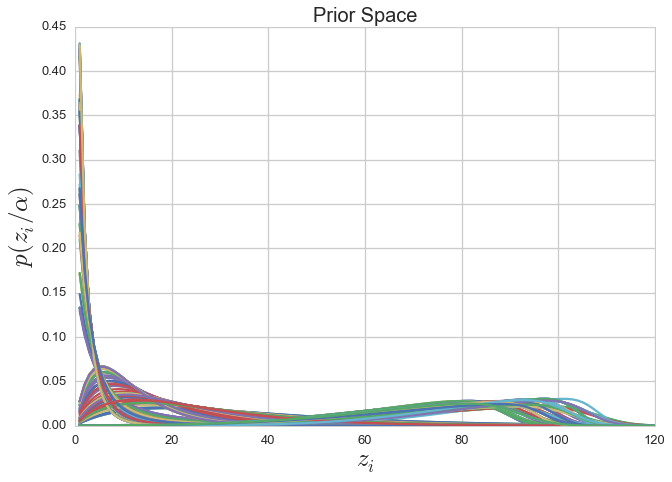

In [65]:
#Define function space for representing priors.

#Priors have values of the order of e-6 so we need to provide special encoders and eval points.
#Furthermore, priors are very high dimensional, so it will be nice to compress them to a lower dimension as well

def prior_space():
    idx = np.random.randint(0, len(pZA))
    return pZA[idx]

import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

n_basis = 20

space = nengo.FunctionSpace(
        nengo.dists.Function(prior_space),
        n_basis=n_basis)


from copy import deepcopy
space_raw = deepcopy(space.space)


data = space.space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Prior Space", fontsize=20)
plt.ylabel(r'$p(z_i/\alpha)$', fontsize=25)
plt.xlabel(r'$z_i$', fontsize=25) 
#plt.ylim(0,0.03)

### Building the model

In [100]:
global p, i, k
global spy_x
k = 0
i = 0
beta = 0.65
dt = 0.001
srch_space = M

num_observations = 5#0
# initial input
X = draw(1, num_observations+1)
_pXZ = compute_lik(X[0])
p = _pXZ[0]

a =  np.random.randint(0, M) 
L = np.zeros(M)   
pxz = p * pZA[a, :]   # pZA changing every one second, p (likelihood) changes with each incoming sample 
input = (pxz / np.sum(pxz))

model = nengo.Network(label='learn prior') 
with model:
    
    def ctx_drive(t, x):
        "t - current time in ms"
        "x - cortical state in cortex2 ensemble"
        global k, p, i, spy_x
        change_freq = 3
        
        # reconstruct the prior back to 120dim space
        # normalize reconstructed prior
        # x = np.dot(x, space._basis.T)   # gives the same result as below
        x = space.reconstruct(x)
        if sum(x) != 0:
            x = x/np.sum(x) 
        
        # swap
        if t%1<0.5:
            if t<1:
                spy_x = x
            else:    
                temp = x
                x = spy_x
                spy_x = temp
        
        # every 'change_freq' iterations, a new sample comes in (so the likelihood changes)
        if t%change_freq == 0 and t!=0:
            i = i+1
            p = _pXZ[i]
        
        # updating every 1 second, so each iteration is 1s 
        if t%1 == 0 and t!=0:
            k = k+1         
        
        nk = np.power(float(np.floor(k)+2), -beta)
        if t<1:
            return nk*input
             
        # every 1 second, a new prior (from previous iteration) is used to update ctx
        # p is the likelihood and x is the prior selected from previous iteration
        pxz = p * x   
        if pxz.any():
            pxz = pxz / np.sum(pxz)
        else:
            # pxz has all zeros
            #print "pxz = zero"
            pass
         
        return nk*pxz
     
            
    def ctx_to_bg(t, x):
        # scale x such that all  
        # why does x sometimes have all equal elements??
        if x.any():
            new_xmax = 1
            new_xmin = 0
            x_min = np.min(x)
            x_max = np.max(x)
            if x_min != x_max:
                x = (new_xmax - new_xmin)/(x_max - x_min)*(x - x_min)+ new_xmin 
            else:
                #all elements in the list are equal
                x = x/len(x)
        return x
    
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Cortical Processing
    
    
    # node providing cortical input to the model - sample observations as sensory input 
    cortex_in = nengo.Node(output=ctx_drive, size_out=max_age, size_in=space.n_basis)
    
    # Cortex representing the summary statistics of current and previous iterations
    # This is the input for WTA network and the Memory network
    # This is also where addition of current and previous statistics takes place
    ensemble_ctx = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=srch_space, neuron_type=nengo.LIF()) 
    for ens in ensemble_ctx.all_ensembles:
        ens.encoders = nengo.dists.Choice([[-1.]]) 
        ens.eval_points = nengo.dists.Uniform(-1, 0.0)
        ens.radius = 1
        ens.intercepts=nengo.dists.Uniform(-0.6, 1.)
              
           
    # connect sensory input to cortex
    # logpZA.T => (srch_space, max_age) where max_age = 120
    # Divide by 10 to bring it in the representational range of neurons
    # 10 is just a constant scaling factor and doesn't impact the algorithm
    nengo.Connection(cortex_in, ensemble_ctx.input, transform=logpZA/10.0)
     
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Winner take all network - Independant Accumulator
    # needs to be reset through inhibition before every iteration.
    
    wta = IA(d=srch_space, n_neurons=150, dt=dt)
    wta.x.add_neuron_input()

    def inhib(t):
        if t%1 > 0.5:
            return 2.0 
        else:
            return 0
    
    #Connecting inhibit population to error population
    inhibit = nengo.Node(inhib)
    nengo.Connection(inhibit, wta.x.neuron_input, 
                     transform=[[-2]] * wta.x.n_neurons_per_ensemble * wta.x.n_ensembles, synapse=0.01)
    
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Prepare input for wta network
    # Input should be positive and scaled to span the entire range from 0-1 
    # in order to space apart the competing values
    
    
    # node providing a constant bias of 1 to convert the values in 'ensemble_ctx' 
    # from -ve to +ve before wta input
    node_const = nengo.Node(output=np.ones(srch_space), size_out=srch_space)
    
    # node used for scaling the values in 'ensemble_ctx' to span entire range from 0-1
    scale_node = nengo.Node(output=ctx_to_bg, size_in=srch_space, size_out=srch_space)
    
    # node to add the bias before scaling
    addbias_node = nengo.Node(size_in=srch_space, size_out=srch_space)
    nengo.Connection(node_const, addbias_node)
    nengo.Connection(ensemble_ctx.output, addbias_node)
        
    # scale the values only after the bias has been added
    nengo.Connection(addbias_node, scale_node) 
    nengo.Connection(scale_node, wta.input)

    
    ### ------------------------------------------------------------------------------------------------------- ###  
    

    # This leads to (1-n(k))u
    def mem_to_ctx(t, x):
        if t<1:
            return 0
        global k
        nk = np.power(float(np.floor(k)+2), -beta)
        return x * (1 - nk) 
      
   
    # gating signal for memory unit 2
    def gate_mem2(t, x):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "close the gate in first half, open in second"
        gate_input = 1
        if t%1 >= 0.5 and t%1 < 1:
            gate_input = 0
        elif t%1 >= 0 and t%1 < 0.5:
            gate_input = 1
        return gate_input 
    
    
    # gating signal for memory unit 1
    def gate_mem1(t, x):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "open the gate in first half, close in second"
        gate_input = 1
        if t%1 >= 0.5 and t%1 < 1:
            gate_input = 1
        elif t%1 >= 0 and t%1 < 0.5:
            gate_input = 0
        return gate_input
    
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Memory Network
    
    
    # build two difference integrator units
    memory1 = InputGatedMemory(n_neurons=100, n_neurons_diff=30, dimensions=srch_space) 
    memory2 = InputGatedMemory(n_neurons=100, n_neurons_diff=30, dimensions=srch_space)
    
    # provide gating signal to unit 1
    gate_in1 = nengo.Node(output=gate_mem1, size_out=1, size_in=1)
    nengo.Connection(gate_in1, memory1.gate)
    
    # provide gating signal to unit 2
    gate_in2 = nengo.Node(output=gate_mem2, size_out=1, size_in=1)
    nengo.Connection(gate_in2, memory2.gate)
    
    nengo.Connection(ensemble_ctx.output, memory1.input, synapse=0.02)
    nengo.Connection(memory1.output, memory2.input, synapse=0.02)
    
    # node is needed to multiply by updated (1-nk) over time
    node_mem = nengo.Node(output=mem_to_ctx, size_in=srch_space, size_out=srch_space)
    nengo.Connection(memory2.output, node_mem, synapse=0.02)  
    nengo.Connection(node_mem, ensemble_ctx.input)


    ### ------------------------------------------------------------------------------------------------------- ###  
    # Cortex updates at the end of an iteration
    # The winning prior needs to be stored n the cortex but the values
    # are too small, so we need special eval points and encoders.
    # Moreover dimensionality reduction is important here for computational efficiency
    
    
    # ensemble to store the winning prior for the current iteration
    # works perfectly in direct mode so no error due to compression
    cortex1 = nengo.Ensemble(n_neurons=200, dimensions=space.n_basis,
                         encoders=space.project(space_raw),
                         eval_points=space.project(space_raw),
                         neuron_type = nengo.LIF()
                         )  
    
    dummy_ctx = nengo.Ensemble(n_neurons=1, dimensions=max_age, neuron_type = nengo.Direct())  
    
    def project(x):
        return space.project(x)
    
    
    # pZA.T => (max_age, srch_space)
    # function is applied before the transform when both are on a connection
    # but we want it the other way around, therefor dummy_ctx (a direct mode ensemble) is used
    nengo.Connection(wta.output, dummy_ctx, transform=pZA.T, synapse=0.02)
    nengo.Connection(dummy_ctx, cortex1, function=project)
    
    # prior is sent to the node 'cortex_in', where it is processed with the likelihood  
    # based on the incomding sensory observation to determine the posterior for next iteration.
    nengo.Connection(cortex1, cortex_in)
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Probes
    
    # wta 
    wta_doutp = nengo.Probe(wta.output, synapse=0.02)
    wta_statep = nengo.Probe(wta.x.output, synapse=0.02)
    wta_inp = nengo.Probe(wta.input, synapse=0.02)
    
    # ctx 
    cortex1_p = nengo.Probe(cortex1, synapse=0.02)
    ensctx_p = nengo.Probe(ensemble_ctx.output, synapse=0.02)
    ctx_inp = nengo.Probe(cortex_in, synapse=0.02)
    dummy_ctxp = nengo.Probe(dummy_ctx, synapse=0.02)
    
    # memory
    memory1_ip = nengo.Probe(memory1.input, synapse=0.02)
    memory1_op = nengo.Probe(memory1.output, synapse=0.02)
    memory1_gp = nengo.Probe(memory1.gate, synapse=0.02)
    memory2_ip = nengo.Probe(memory2.input, synapse=0.02)
    memory2_op = nengo.Probe(memory2.output, synapse=0.02)
    memory2_gp = nengo.Probe(memory2.gate, synapse=0.02)
    node_memp = nengo.Probe(node_mem, synapse=0.02)
   

sim = nengo.Simulator(model, dt=dt)  # Create the simulator
sim.run(3*num_observations)                  # Run it for specified number of observations  

Building finished in 0:00:07.                                                   
Simulating finished in 0:01:52.                                                 


In [101]:
print "Memory1(V): ", memory1.n_neurons
print "Memory2(V): ", memory2.n_neurons
print "Ens Ctx(V): ", ensemble_ctx.n_neurons
print "Wta(V):     ", wta.n_neurons
print "Cortex1:    ", cortex1.n_neurons
print "Total neurons in the model:", memory1.n_neurons+memory2.n_neurons+ensemble_ctx.n_neurons+wta.n_neurons+cortex1.n_neurons

per_sample = memory1.n_neurons/srch_space + memory2.n_neurons/srch_space + \
             ensemble_ctx.n_neurons/srch_space + wta.n_neurons/srch_space
print "Total neurons per sample: ", per_sample

Memory1(V):  14040
Memory2(V):  14040
Ens Ctx(V):  5400
Wta(V):      16200
Cortex1:     200
Total neurons in the model: 49880
Total neurons per sample:  460


### WTA output across iterations

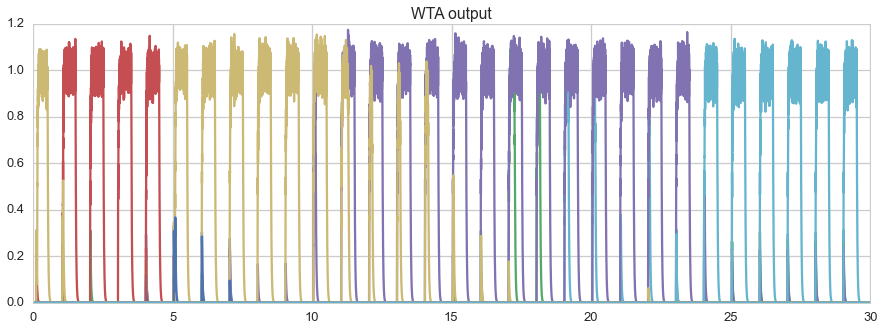

In [80]:
plt.figure(figsize=(15, 5))
plt.plot(sim.trange(), sim.data[wta_doutp])
plt.title("WTA output")

### Plot the optimal prior found by the model

RMSE (model):  0.00275737270353
RMSE (actual):  0.00300628805749
Reconstruction Error:  0.000248915353964


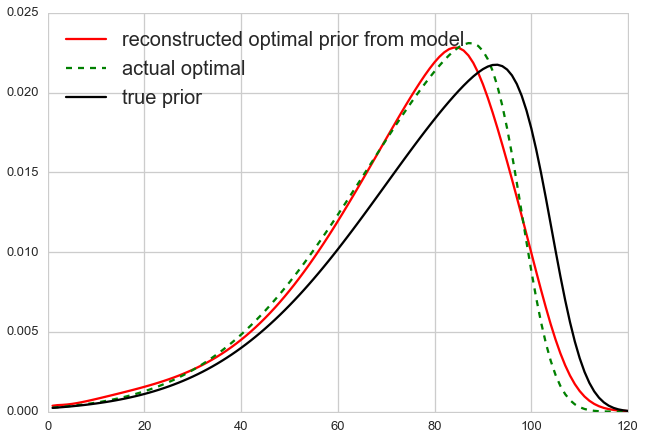

In [103]:
pred_index = 14
idx = -510 
wta_output = sim.data[wta_doutp][idx] 

test_ind = np.argmax(wta_output)
data = sim.data[cortex1_p][idx]   # cortex - prior representation 
data = space.reconstruct(data)    #np.dot(data, space._basis.T)
data = data/np.sum(data)

rmse_act = rmse(pZA[test_ind, :], pZA[pred_index, :])
rmse_model = rmse(data, pZA[pred_index, :])
print "RMSE (model): ", rmse_model
print "RMSE (actual): ", rmse_act
print "Reconstruction Error: ", np.abs(rmse_act-rmse_model)

plt.figure()
plt.plot(thetas, data, 'r', label="reconstructed optimal prior from model")
plt.plot(thetas, pZA[test_ind, :], 'g--', label="actual optimal")
plt.plot(thetas, pZA[pred_index, :], 'k', label="true prior")
plt.legend(loc='upper left', fontsize=20)

### Test compression/reconstruction in cortex1 ensemble at any point during the simulation

RMSE reconstruct and expected recons:  0.000856822188079
RMSE reconstruct and prediction:  0.0125053628825


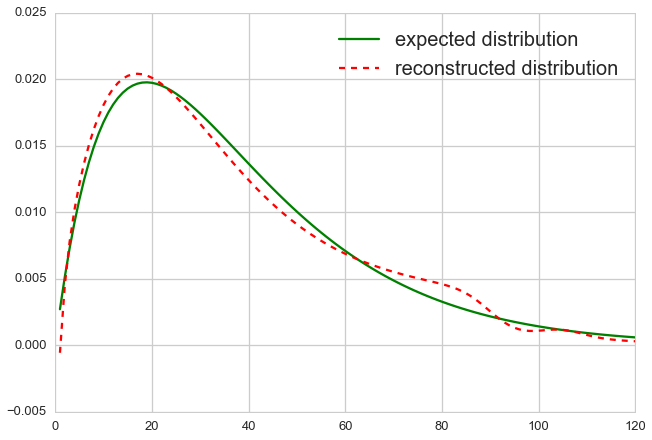

In [111]:
# for testing cortex1 - compression/reconstruction at any point during the simulation
idx = 400

thal_output = sim.data[wta_doutp][idx]
test_idx  =  np.argmax(thal_output)

Z = pZA[test_idx, :]
U = sim.data[cortex1_p][idx]
recnstct = space.reconstruct(U)
recnstct = recnstct/np.sum(recnstct)  #make sure reconstructed prior is normalized

plt.figure()
plt.plot(thetas, Z, 'g', label="expected distribution")  # expected
plt.plot(thetas, recnstct, 'r--', label="reconstructed distribution")  # model obtained

print "RMSE reconstruct and expected recons: ", rmse(recnstct, Z)
print "RMSE reconstruct and prediction: ", rmse(recnstct, pZA[pred_index, :])
plt.legend(loc='upper right', fontsize=20)

In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model)